In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from typing import List, Dict, Callable
from collections import defaultdict

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [3]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5)
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys()), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size,
    )

def tmap_dic_to_df(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            tmap_names.append(t.name)
            tmaps.append(np.zeros(len(tmap_dic)))
        break
        
    tmap = np.zeros(len(tmap_dic), dtype=np.float)
    for i, entry in enumerate(tmap_dic):
        sample_id.append(entry)
        for it, t in enumerate(tmap_dic[entry]):
            tmaps[it][i] = tmap_dic[entry][t]
    dd = {'sample_id' : sample_id}
    for name, tmap in zip(tmap_names, tmaps):
        dd[name] = tmap
    return pd.DataFrame(dd)

In [4]:
a = tmaps_with_properties_from_keys(
    '/home/erik/partners_ecg/hd5/2018-01', 
    {
        'partners_ecg_rate': lambda x: x > 0,
        'partners_ecg_pr': lambda x: x > 0,
        'partners_ecg_qt': lambda x: x > 0,
        'partners_ecg_qtc': lambda x: x > 0,        
        'partners_ecg_qrs': lambda x: x > 0
    },
    search_size = 20000
)
dd = tmap_dic_to_df(a)
dd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bcdd2aa20>,
      dtype=object)

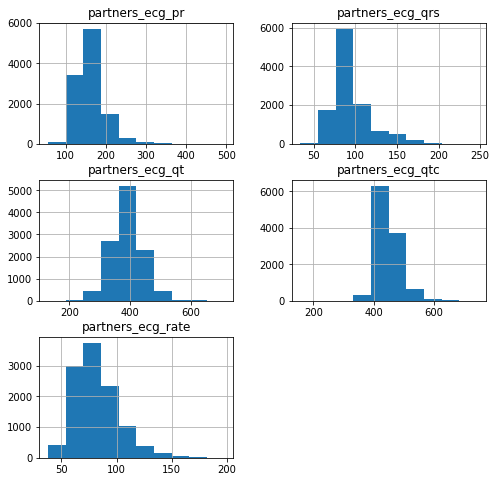

In [6]:
%matplotlib inline
dd.hist(figsize=(8, 8))

In [7]:
dd.mean()

partners_ecg_rate     81.620467
partners_ecg_pr      161.040738
partners_ecg_qt      390.995792
partners_ecg_qtc     446.505327
partners_ecg_qrs      94.709106
dtype: float64

In [8]:
dd.std()

partners_ecg_rate    20.352292
partners_ecg_pr      35.003017
partners_ecg_qt      50.923113
partners_ecg_qtc     39.762255
partners_ecg_qrs     22.610711
dtype: float64

In [9]:
a = tmaps_with_properties_from_keys(
    '/home/erik/partners_ecg/hd5/2019-01', 
    {
        'partners_ecg_rate': lambda x: x > 0,
        'partners_ecg_pr': lambda x: x > 0,
        'partners_ecg_qt': lambda x: x > 0,
        'partners_ecg_qtc': lambda x: x > 0,        
        'partners_ecg_qrs': lambda x: x > 0
    },
    search_size = 20000
)
dd = tmap_dic_to_df(a)
dd

,sample_id,partners_ecg_rate,partners_ecg_pr,partners_ecg_qt,partners_ecg_qtc,partners_ecg_qrs
0,000028852-2019-01-19-10-57-56,86.0,170.0,398.0,476.0,84.0
1,000028852-2019-01-23-07-05-13,76.0,178.0,432.0,486.0,88.0
2,000028852-2019-01-23-11-05-48,77.0,168.0,394.0,445.0,78.0
3,000028852-2019-01-24-03-45-43,72.0,172.0,422.0,462.0,74.0
4,000031305-2019-01-01-09-47-43,112.0,152.0,298.0,406.0,84.0
...,...,...,...,...,...,...
12070,006559726-2019-01-27-15-39-17,80.0,174.0,366.0,422.0,88.0
12071,006559898-2019-01-27-18-36-24,95.0,166.0,360.0,452.0,76.0
12072,062541-2019-01-05-11-18-30,65.0,176.0,418.0,434.0,86.0
12073,071340-2019-01-01-18-22-30,79.0,112.0,404.0,463.0,84.0


In [10]:
dd.mean()

partners_ecg_rate     81.767950
partners_ecg_pr      160.828986
partners_ecg_qt      389.542857
partners_ecg_qtc     444.987909
partners_ecg_qrs      93.935404
dtype: float64

In [11]:
dd.std()

partners_ecg_rate    20.343338
partners_ecg_pr      35.506205
partners_ecg_qt      52.292443
partners_ecg_qtc     40.487247
partners_ecg_qrs     22.371607
dtype: float64